In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            runtime = to_seconds(end) - to_seconds(start)
            if runtime < 0: # we crossed into the next day
                to_midnight = 60*60*24 - to_seconds(start)
                runtime = to_midnight + to_seconds(end)
            r.append(runtime)
    return r

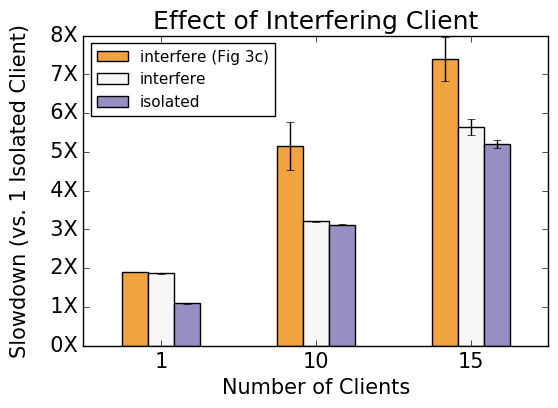

In [72]:
norm = np.mean(parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients1/*isolated*")))

mean = pd.DataFrame(columns=["interfere (Fig 3c)", "interfere", "isolated"])
stds = pd.DataFrame(columns=["interfere (Fig 3c)", "interfere", "isolated"])
clients = [1, 10, 15]
for i in clients:
    j0runs = []
    j1runs = []
    for run in [0, 1, 3]:
        j0 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "-log-run"+str(run)+"/*interfere*"))
        j1 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "-log-run"+str(run)+"/*isolated*"))
        if len(j0) != 0 and len(j1) != 0:
            j0runs.append(np.max(j0/norm))
            j1runs.append(np.max(j1/norm))
    j3 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients" + str(i) + "/*interfere*"))
    mean.loc[len(mean)] = [np.max(j3/norm), np.mean(j0runs), np.mean(j1runs),]
    stds.loc[len(stds)] = [np.std(j3/norm), np.std(j0runs), np.std(j1runs)]
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
mean.plot.bar(ax=ax, yerr=stds, color=['#f1a340', '#f7f7f7', '#998ec3'])
ax.set_ylabel("Slowdown (vs. 1 Isolated Client)")
ax.set_title("Effect of Interfering Client")
ax.set_xlabel("Number of Clients")
ax.legend(fontsize=11, loc='upper left')
ax.set_yticklabels(['{:3.0f}X'.format(x) for x in ax.get_yticks()])
x = ax.set_xticklabels(clients, rotation=0)
fig.savefig('graphs/block-allow.png', bbox_inches='tight', dpi=400)